In [2]:
import numpy as np
import matplotlib.pyplot as plt

from importations.requirement3_1 import *

Generating the day dependent demand curve:

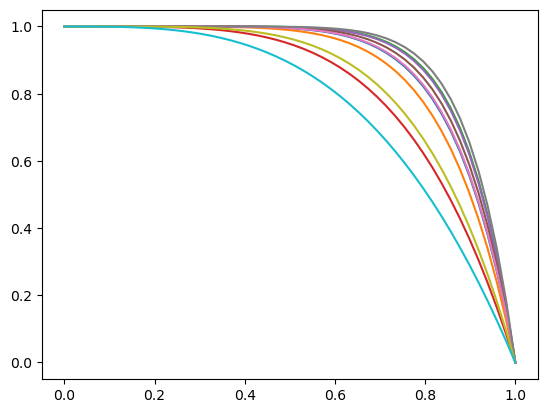

In [3]:
T = 10
K = 50
cost = 0.1
np.random.seed(18)
prices = np.linspace(0,1,K)
for t in range(T):
 b = np.random.uniform(3,10)
 conversion_probability = lambda p: 1- p**b
 plt.plot(prices, conversion_probability(prices)) #Everytime a curve is generated depending on the choice of the coefficient b

The price during the day will depend on the particular interval, since every interval will generate its own noise.

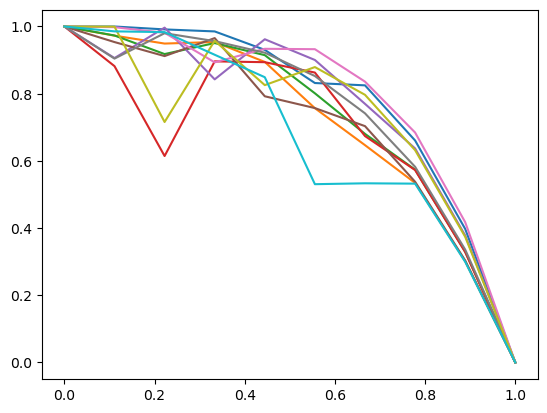

In [4]:
#Creating the noise:
n_epochs = 10
K = 10
cost = 0.1
np.random.seed(18)
prices = np.linspace(0,1,K)
mu = []
ru = [] # The rewards in expectation
for t in range(n_epochs):
 b = np.random.uniform(3,5) # A random coefficient is chosen for a new demand curve
 conversion_probability = lambda p: 1- p**b
 y_obs = np.array([])
 y2_obs = np.array([])
 i0 = 1
 f0 = K-4
 for i in range(0,K):
     noise = np.random.normal(0, 0.25)
     if i < i0 or i > f0:
       new_y_obs = conversion_probability(prices[i]) 
       new_y2_obs = conversion_probability(prices[i])*(prices[i] - cost) 
     else: 
       new_y_obs = conversion_probability(prices[i]) - noise**2
       new_y2_obs =  (conversion_probability(prices[i]) - noise**2)*(prices[i] - cost)
     y_obs = np.append(y_obs,new_y_obs)
     y2_obs = np.append(y2_obs, new_y2_obs)
 mu.append(y_obs)
 ru.append(y2_obs)
 plt.plot(prices, y_obs) #Everytime a curve is generated depending on the choice of the coefficient b



We can also create an environment with an evolving demand curve without noise: (To understand the effect of the noise):

In [5]:
n_epochs = 10
K = 10
cost = 0.1
np.random.seed(18)
prices = np.linspace(0,1,K)
mu_nn = []
ru_nn = [] # The rewards in expectation
for t in range(n_epochs):
 b = np.random.uniform(3,5) # A random coefficient is chosen for a new demand curve
 conversion_probability = lambda p: 1- p**b
 y_obs = np.array([])
 y2_obs = np.array([])
 for i in range(0,K):
    
    new_y_obs = conversion_probability(prices[i]) 
    new_y2_obs = conversion_probability(prices[i])*(prices[i] - cost )
     
    y_obs = np.append(y_obs,new_y_obs)
    y2_obs = np.append(y2_obs, new_y2_obs)
 mu_nn.append(y_obs)
 ru_nn.append(y2_obs)

To see the difference between the two, we can plot a single curve (noise free) and impose a one with noise on it in a single graph.

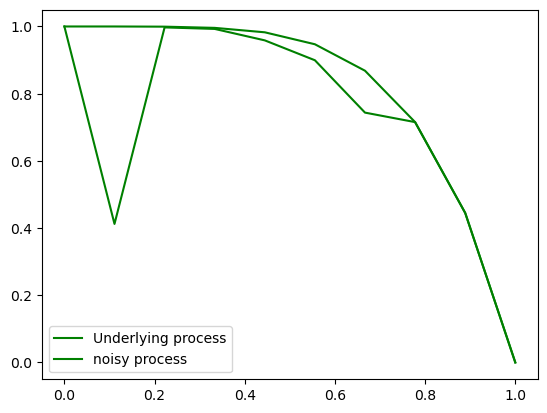

In [6]:
K = 10
prices = np.linspace(0,1,K)
np.random.seed(18)
conversion_probability = lambda p: 1- p**5
y_obs = np.array([])
i0 = 1
f0 = K-4
for i in range(0,K):
 noise = np.random.normal(0, 0.35)
 if i < i0 or i > f0:
       new_y_obs = conversion_probability(prices[i]) 
 else: new_y_obs = conversion_probability(prices[i]) - noise**2
 y_obs = np.append(y_obs,new_y_obs)

plt.plot(prices, conversion_probability(prices), label='Underlying process', color = 'Green')
plt.plot(prices, y_obs, label='noisy process', color = 'green')
plt.title('')
plt.legend()
plt.show()

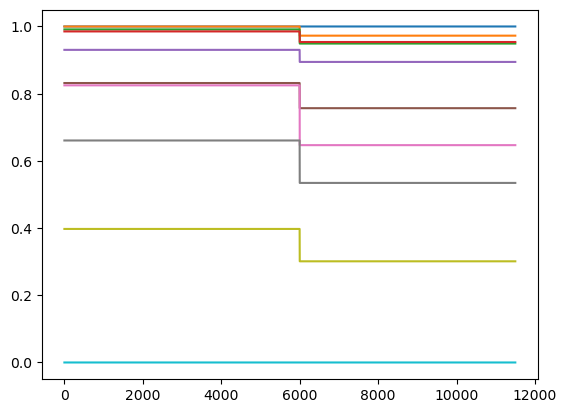

In [7]:
A = ([mu[0]]*6000+ [mu[1]]*5500) # A tuple with an array repeated 11500 times
A_nn = ([mu_nn[0]]*6000+ [mu_nn[1]]*5500)
t = np.arange(11500)
plt.plot(t, A)#Each color corresponds to a single price, the conversion rate of that price is dynamically changing

The clairvoyant should pick the policy that always pulls the optimal price that itself is dynamic and changining when a certain rounds passes.(Optimal policy clairvoyant)

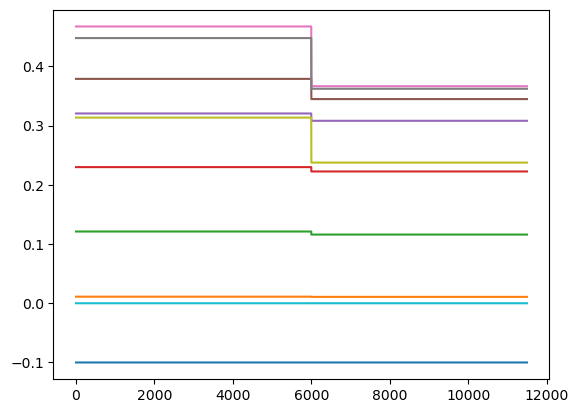

In [8]:
B = ([ru[0]]*6000+ [ru[1]]*5500)
B_nn = ([ru_nn[0]]*6000+ [ru_nn[1]]*5500)
t = np.arange(11500)
plt.plot(t, B)

In [9]:
env = NonstationaryPricingEnv(A, prices,cost, 500,seed=17)
env.rewards #Passing the tuble to the environment and it will return another tuble with rewards for every price and every regime
env.round(0)

-0.1

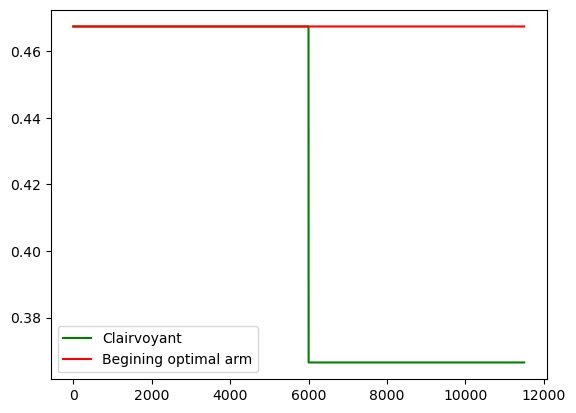

In [10]:
expected_clairvoyant_rewards = np.array(B).max(axis=1)
stationaryoptimal = np.zeros(11500)
for i in range(11500):
 stationaryoptimal[i] = B[1][np.array(ru[0]).argmax(axis=0)]

plt.plot(t, expected_clairvoyant_rewards, color = 'green', label = 'Clairvoyant')
plt.plot(t, stationaryoptimal, color = 'red', label = 'Begining optimal arm')
plt.legend()


A UCB1 agent against an environment with two only abrubt changes

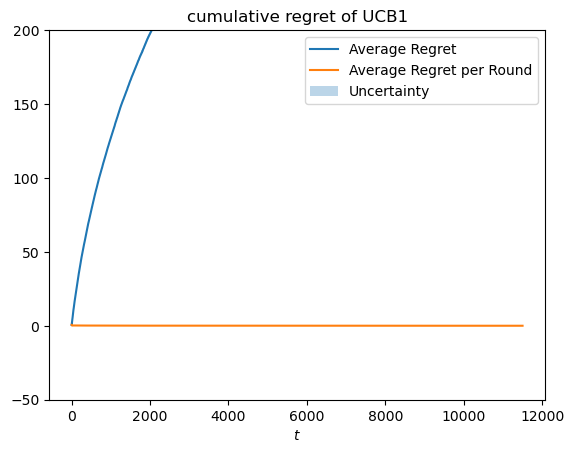

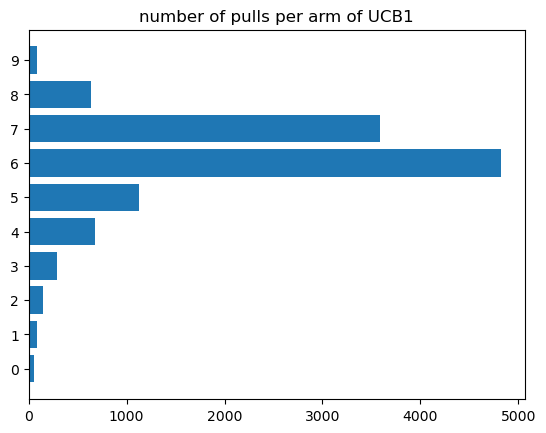

In [11]:
T = 11500

K  = 10
prices = np.linspace(0,1,K)
cost = 0.1
expected_clairvoyant_rewards = np.array(B).max(axis=1)
expected_clairvoyant_rewards_noise = np.array(B).max(axis=1)
n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryPricingEnv(A, prices,cost, T,seed)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)
        
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret_st = regret_per_trial.mean(axis=0)
regret_sd_st = regret_per_trial.std(axis=0)

t = range(1, T + 1) 
plt.plot(np.arange(T), average_regret_st, label='Average Regret')
plt.plot(np.arange(T), average_regret_st/ np.array(t), label='Average Regret per Round')
plt.ylim(-50, 200)
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret_st-regret_sd_st/np.sqrt(n_trials),
                average_regret_st+regret_sd_st/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2','3','4','5','6','7','8','9'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')
plt.show();


    

What if UCB faces a noise free environment:

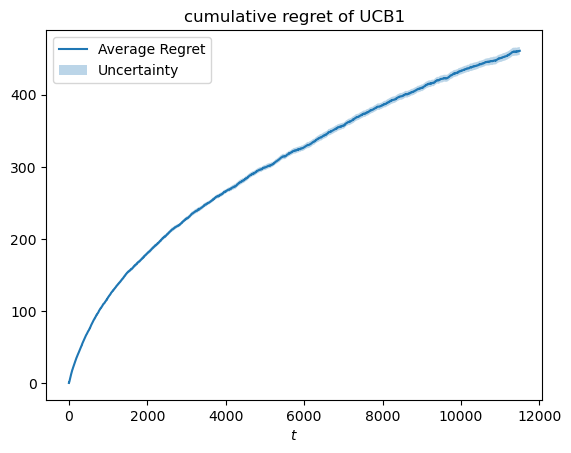

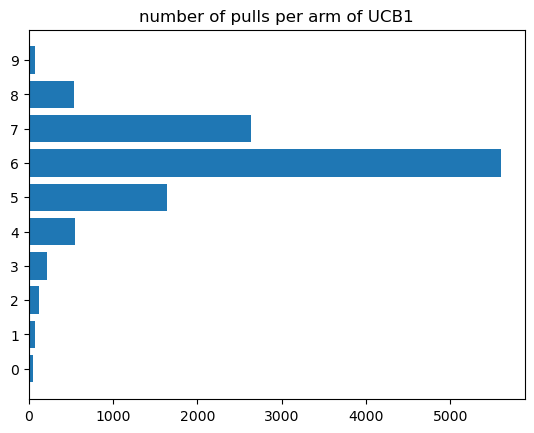

In [12]:
T = 11500

K  = 10
prices = np.linspace(0,1,K)
cost = 0.1
expected_clairvoyant_rewards_nn = np.array(B_nn).max(axis=1)
n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryPricingEnv(A_nn, prices,cost, T,seed)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)
        
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards_nn-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret_st_nn = regret_per_trial.mean(axis=0)
regret_sd_st_nn = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret_st_nn, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret_st_nn-regret_sd_st_nn/np.sqrt(n_trials),
                average_regret_st_nn+regret_sd_st_nn/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2','3','4','5','6','7','8','9'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')
plt.show();


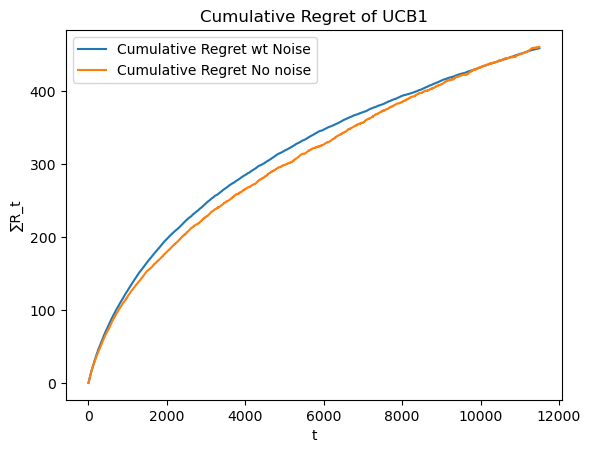

In [13]:
plt.plot(average_regret_st, label="Cumulative Regret wt Noise")
plt.plot(average_regret_st_nn, label="Cumulative Regret No noise")
plt.xlabel('t')
plt.ylabel('∑R_t')
plt.title('Cumulative Regret of UCB1')
plt.legend()
plt.show()

As the number of arms increase UCB1 incurs a linear regret

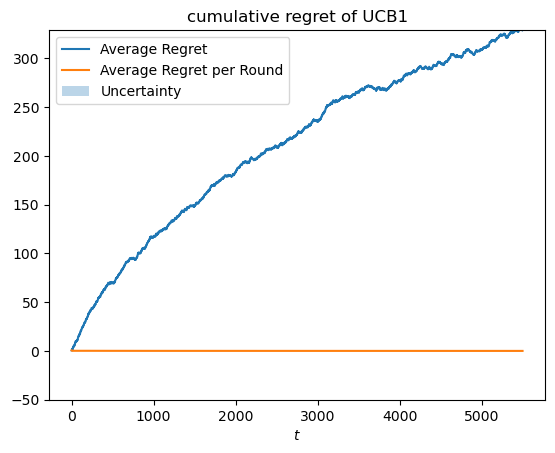

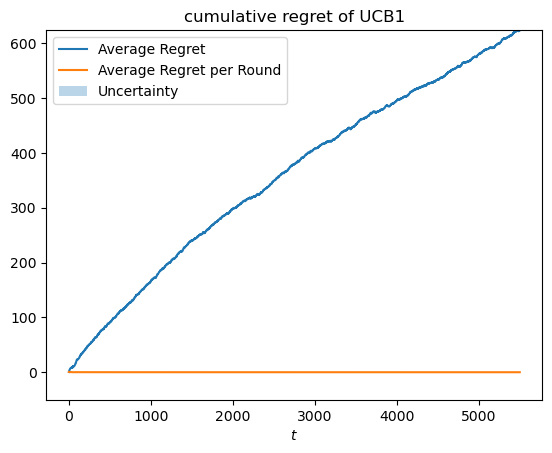

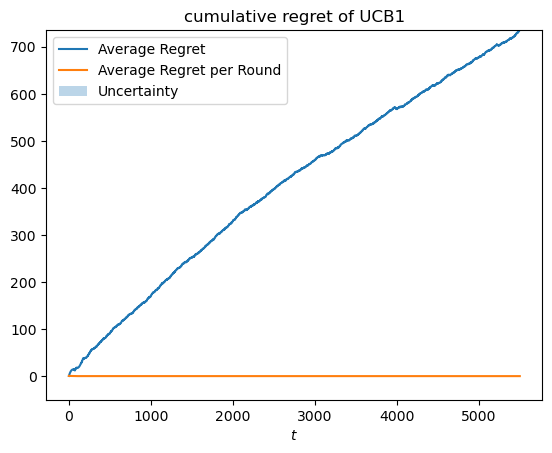

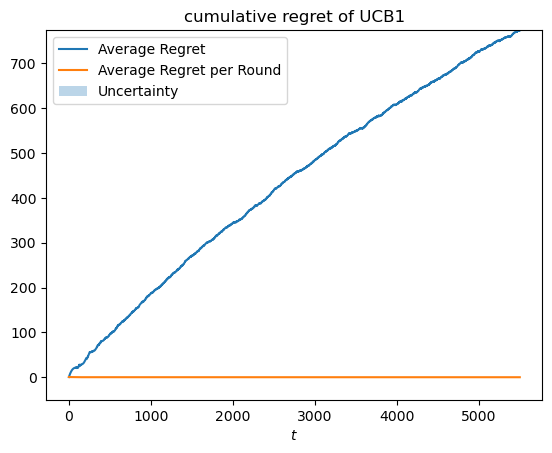

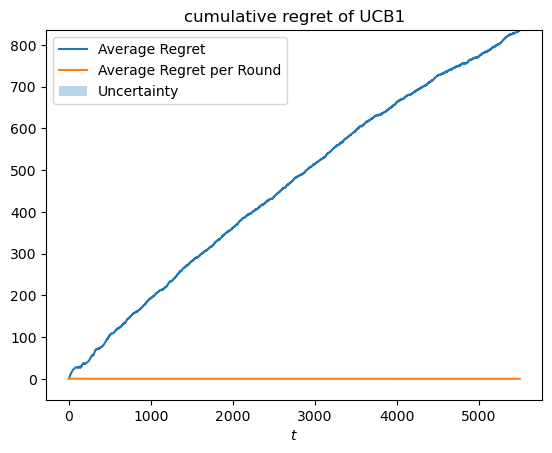

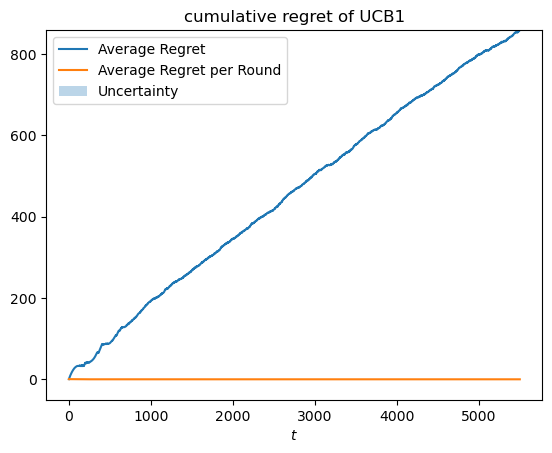

In [14]:
G = np.linspace(10,200,6)
T = 5500
n_epochs = 5




for i in G:
    
  n_epochs = 5

  cost = 0.1
  np.random.seed(18)
  prices = np.linspace(0,1,int(i))
  mu = []
  ru = [] # The rewards in expectation
  for t in range(n_epochs):
    b = np.random.uniform(3,5) # A random coefficient is chosen for a new demand curve
    conversion_probability = lambda p: 1- p**b
    y_obs = np.array([])
    y2_obs = np.array([])
    i0 = 4
    f0 = int(i)-4
    for j in range(0,int(i)):
       noise = np.random.normal(0, 0.1)
       if j < i0 or j > f0:
         new_y_obs = conversion_probability(prices[j]) 
         new_y2_obs = conversion_probability(prices[j])*(prices[j] - cost )
       else: 
         new_y_obs = conversion_probability(prices[j]) - noise**2
         new_y2_obs =  (conversion_probability(prices[j]) - noise**2)*(prices[j] - cost)
       y_obs = np.append(y_obs,new_y_obs)
       y2_obs = np.append(y2_obs, new_y2_obs)
    mu.append(y_obs)
    ru.append(y2_obs)
  A = ([mu[0]]*2500+ [mu[1]]*1000 + [mu[2]]*2000)
  B = ([ru[0]]*2500+ [ru[1]]*1000 + [ru[2]]*2000)  
  prices = np.linspace(0,1,int(i))
  cost = 0.1
  n_trials = 20
  expected_clairvoyant_rewards = np.array(B).max(axis=1)   
  regret_per_trial = []

  for seed in range(n_trials):
      np.random.seed(seed)
      env = NonstationaryPricingEnv(A, prices,cost, T,seed)
      ucb_agent = UCB1Agent(int(i), T)

      agent_rewards = np.array([])

      for t in range(T):
          a_t = ucb_agent.pull_arm()
          r_t = env.round(a_t)
          ucb_agent.update(r_t)

          agent_rewards = np.append(agent_rewards, r_t)
        
  cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
  regret_per_trial.append(cumulative_regret)

  regret_per_trial = np.array(regret_per_trial)
  average_regret = regret_per_trial.mean(axis=0)
  regret_sd = regret_per_trial.std(axis=0)
  t = range(1, T + 1) 
  plt.plot(np.arange(T), average_regret, label='Average Regret')
  plt.plot(np.arange(T), average_regret/ np.array(t), label='Average Regret per Round')
  plt.ylim(-50, average_regret[T-1])
  plt.title('cumulative regret of UCB1')
  plt.fill_between(np.arange(T),
              average_regret-regret_sd/np.sqrt(n_trials),
              average_regret+regret_sd/np.sqrt(n_trials),
              alpha=0.3,
              label='Uncertainty')
  plt.xlabel('$t$')
  plt.legend()
  plt.show()

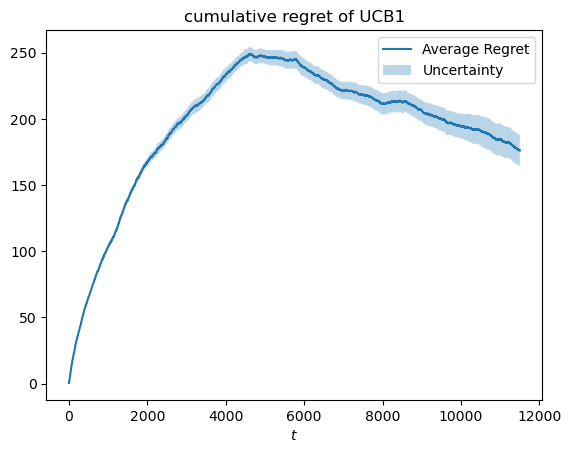

In [15]:
#Creating the noise:
n_epochs = 10
K = 10
cost = 0.1
np.random.seed(18)
prices = np.linspace(0,1,K)
mu = []
ru = [] # The rewards in expectation
for t in range(n_epochs):
 b = np.random.uniform(3,5) # A random coefficient is chosen for a new demand curve
 noise = np.random.normal(0, 0.3)
 conversion_probability = lambda p: 1- p**b
 y_obs = np.array([])
 y2_obs = np.array([])
 i0 = 4
 f0 = K-4
 for i in range(0,K):
     noise = np.random.normal(0, 0.35)
     if i < i0 or i > f0:
       new_y_obs = conversion_probability(prices[i]) 
       new_y2_obs = conversion_probability(prices[i])*prices[i] - cost 
     else: 
       new_y_obs = conversion_probability(prices[i]) - noise**2
       new_y2_obs =  (conversion_probability(prices[i]) - noise**2)*prices[i] - cost
     y_obs = np.append(y_obs,new_y_obs)
     y2_obs = np.append(y2_obs, new_y2_obs)
 mu.append(y_obs)
 ru.append(y2_obs)

A1 = ([mu[0]]*2500+ [mu[1]]*1000 + [mu[2]]*2000 + [mu[3]]*2000 + [mu[4]]*4000) # A tuple with an array repeated 11500 times
B1 = ([ru[0]]*2500+ [ru[1]]*1000 + [ru[2]]*2000 + [ru[3]]*2000 + [ru[4]]*4000) #Tuple for rewards

A2 = ([mu[0]]*1150+ [mu[1]]*1150 + [mu[2]]*1150 + [mu[3]]*1150 + [mu[4]]*1150 + [mu[5]]*1150 + [mu[6]]*1150 + [mu[7]]*1150 + [mu[8]]*1150 + [mu[9]]*1150)
B2 = ([ru[0]]*1150+ [ru[1]]*1150 + [ru[2]]*1150 + [ru[3]]*1150 + [ru[4]]*1150 + [ru[5]]*1150 + [ru[6]]*1150 + [ru[7]]*1150 + [ru[8]]*1150 + [ru[9]]*1150)

T = 11500

K  = 10
prices = np.linspace(0,1,K)
cost = 0.1
expected_clairvoyant_rewards = np.array(B2).max(axis=1)

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryPricingEnv(A2, prices,cost, T,seed)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)
        
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret_ns = regret_per_trial.mean(axis=0)
regret_sd_ns = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret_ns, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret_ns-regret_sd_ns/np.sqrt(n_trials),
                average_regret_ns+regret_sd_ns/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

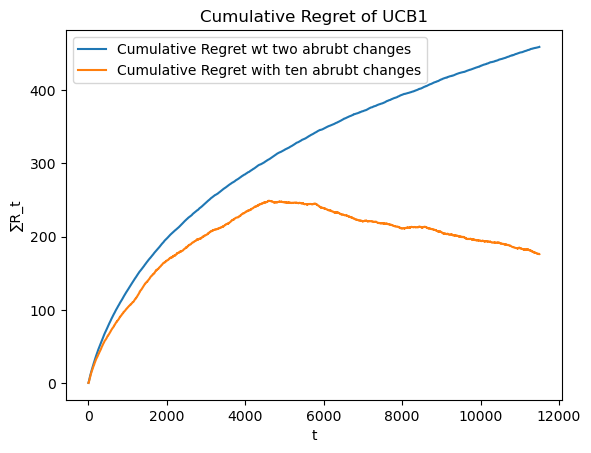

In [16]:
# Plot both on the same graph
plt.plot(average_regret_st, label="Cumulative Regret wt two abrubt changes")
plt.plot(average_regret_ns, label="Cumulative Regret with ten abrubt changes")
plt.xlabel('t')
plt.ylabel('∑R_t')
plt.title('Cumulative Regret of UCB1')
plt.legend()
plt.show()

Sliding window UCB:

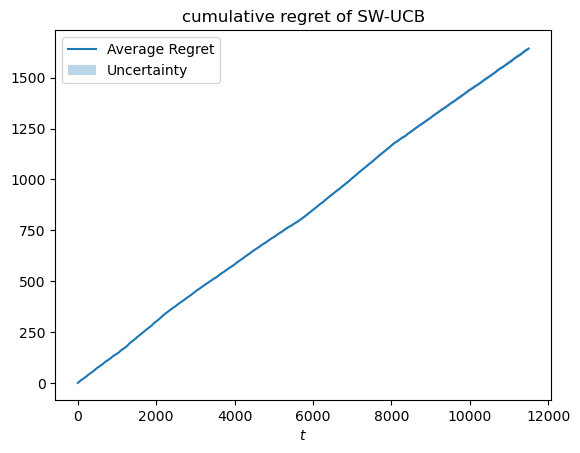

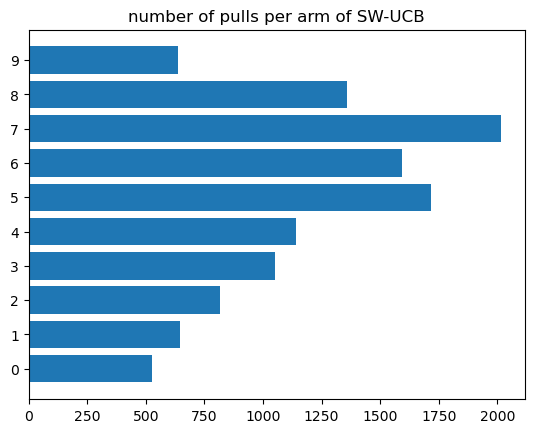

In [17]:
T = 11500
K  = 10
prices = np.linspace(0,1,K)
cost = 0.1
expected_clairvoyant_rewards = np.array(B2).max(axis=1)

U_T = 10 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)



n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryPricingEnv(A2, prices,cost, T,seed)
    ucb_agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret_sw = regret_per_trial.mean(axis=0)
regret_sd_sw = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret_sw, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret_sw-regret_sd_sw/np.sqrt(n_trials),
                average_regret_sw+regret_sd_sw/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


plt.barh(y=['0','1','2','3','4','5','6','7','8','9'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of SW-UCB')
plt.show();

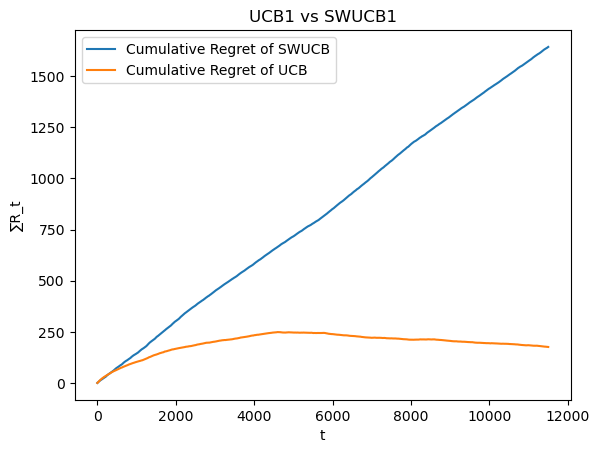

In [18]:
#Plot both on the same graph
plt.plot(average_regret_sw, label="Cumulative Regret of SWUCB")
plt.plot(average_regret_ns, label="Cumulative Regret of UCB ")

plt.xlabel('t')
plt.ylabel('∑R_t')
plt.title('UCB1 vs SWUCB1')
plt.legend()
plt.show()

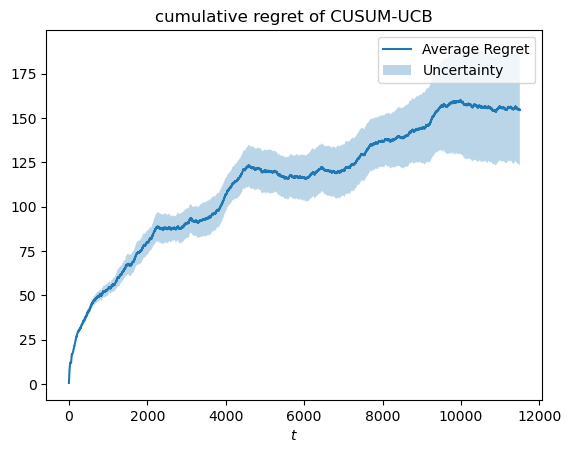

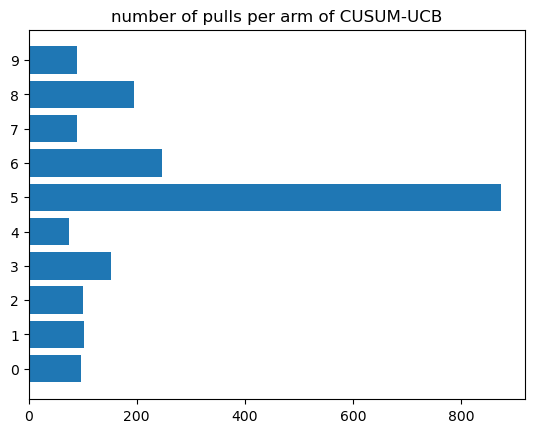

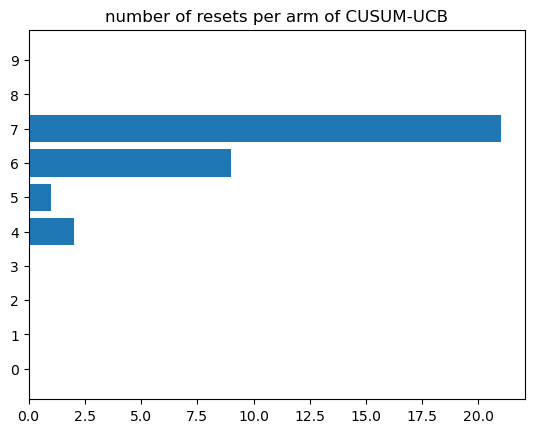

In [19]:
T = 11500
K  = 10
prices = np.linspace(0,1,K)
cost = 0.1
expected_clairvoyant_rewards = np.array(B2).max(axis=1)
U_T = 10 # maximum number of abrupt changes
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryPricingEnv(A2, prices,cost, T,seed)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret_cusum = regret_per_trial.mean(axis=0)
regret_sd_cusum = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret_cusum, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret_cusum-regret_sd_cusum/np.sqrt(n_trials),
                average_regret_cusum+regret_sd_cusum/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2','3','4','5','6','7','8','9'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of CUSUM-UCB')
plt.show();

plt.barh(y=['0','1','2','3','4','5','6','7','8','9'], width=ucb_agent.n_resets)
plt.title('number of resets per arm of CUSUM-UCB')
plt.show();

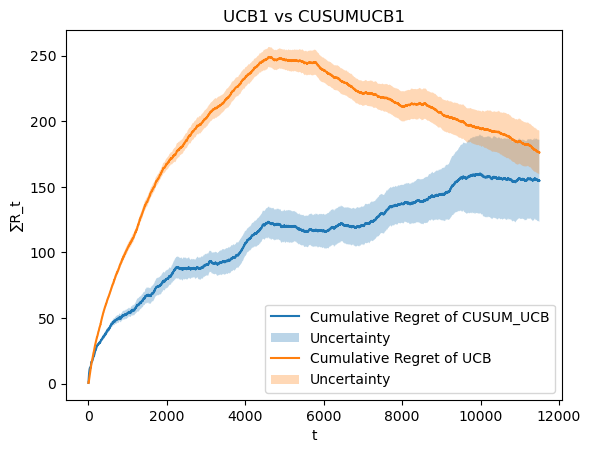

In [20]:
#Plot both on the same graph
plt.plot(average_regret_cusum, label="Cumulative Regret of CUSUM_UCB")
plt.fill_between(np.arange(T),
                average_regret_cusum-regret_sd_cusum/np.sqrt(n_trials),
                average_regret_cusum+regret_sd_cusum/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(average_regret_ns, label="Cumulative Regret of UCB ")
plt.fill_between(np.arange(T),
                average_regret_ns-regret_sd_ns/np.sqrt(n_trials),
                average_regret_ns+regret_sd_ns/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('t')
plt.ylabel('∑R_t')
plt.title('UCB1 vs CUSUMUCB1')
plt.legend()
plt.show()